Dataset shape: (20640, 9)

Data overview:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  PRICE  
0    -122.23  4.526  
1    -122.22  3.585  
2    -122.24  3.521  
3    -122.25  3.413  
4    -122.25  3.422  

Data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  floa

 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

C:\Users\ay569\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


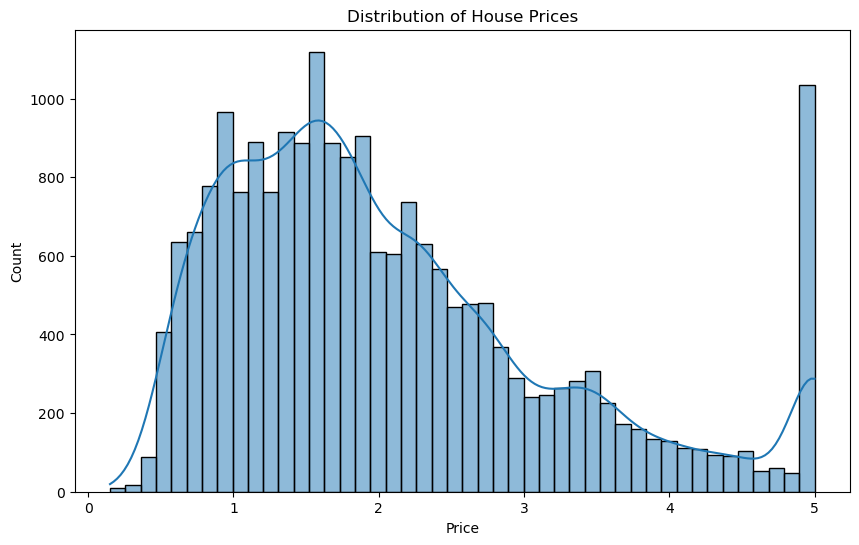

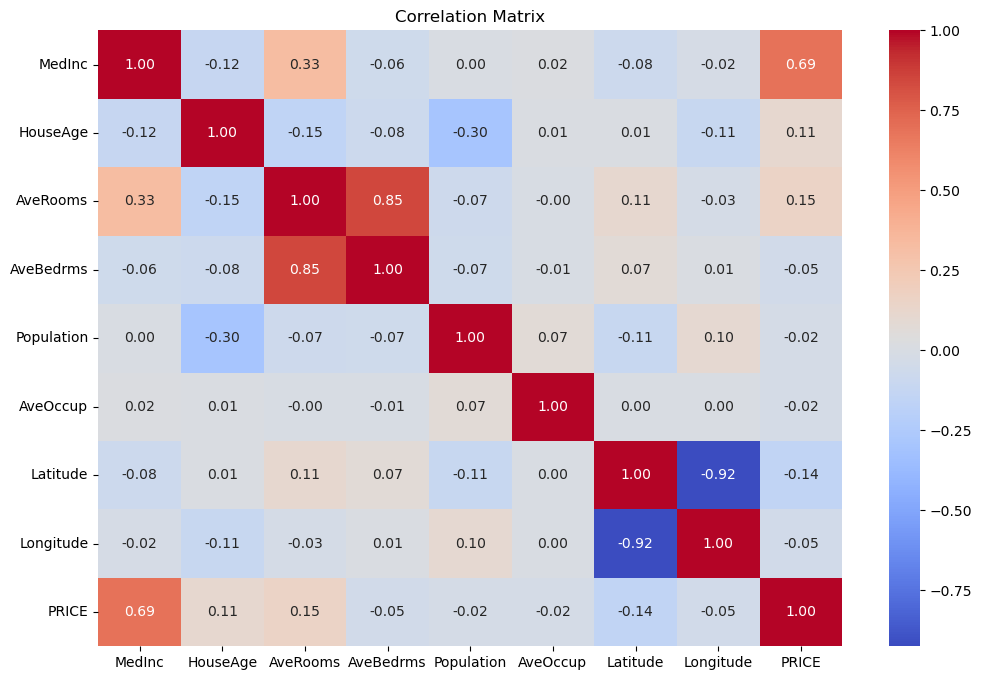

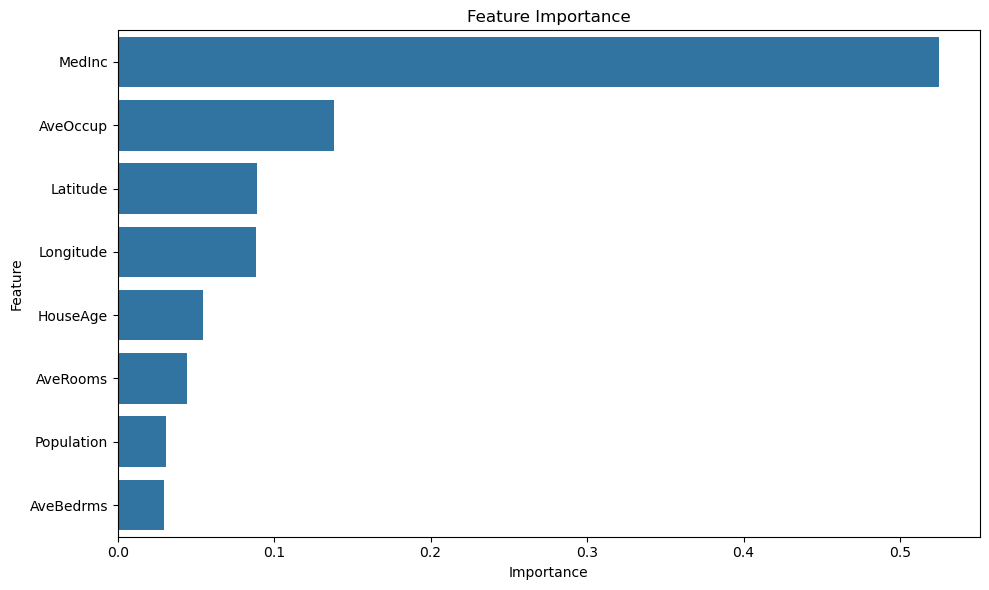

In [1]:
# Complete Data Science Project: House Price Prediction with Deployment

# --- PART 1: SETUP AND DATA COLLECTION ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pickle
import os
from flask import Flask, request, jsonify, render_template

# Data collection - using the Boston Housing dataset
# Note: In a real project, you might download data from an API or database
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['PRICE'] = housing.target

# --- PART 2: EXPLORATORY DATA ANALYSIS ---
print("Dataset shape:", df.shape)
print("\nData overview:")
print(df.head())
print("\nData information:")
print(df.info())
print("\nStatistical summary:")
print(df.describe())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Visualize the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['PRICE'], kde=True)
plt.title('Distribution of House Prices')
plt.xlabel('Price')
plt.savefig('price_distribution.png')  # Save for the web app

# Correlation analysis
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png')  # Save for the web app

# --- PART 3: DATA PREPROCESSING ---
# Split the data
X = df.drop('PRICE', axis=1)
y = df['PRICE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create preprocessing pipeline
numeric_features = X.columns.tolist()
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# --- PART 4: MODEL BUILDING AND EVALUATION ---
# Linear Regression Model
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
lr_predictions = lr_pipeline.predict(X_test)
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_r2 = r2_score(y_test, lr_predictions)

print("\nLinear Regression Results:")
print(f"MSE: {lr_mse:.4f}")
print(f"R²: {lr_r2:.4f}")

# Random Forest Model
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

rf_pipeline.fit(X_train, y_train)
rf_predictions = rf_pipeline.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

print("\nRandom Forest Results:")
print(f"MSE: {rf_mse:.4f}")
print(f"R²: {rf_r2:.4f}")

# Select the best model (Random Forest in this case)
best_model = rf_pipeline

# Feature importance
feature_importances = best_model.named_steps['regressor'].feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.tight_layout()
plt.savefig('feature_importance.png')  # Save for the web app

# Save the model
with open('house_price_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# --- PART 5: MODEL DEPLOYMENT WITH FLASK ---
# Create a Flask application
app = Flask(__name__)

# Load the saved model
model = pickle.load(open('house_price_model.pkl', 'rb'))

# Create templates directory and HTML files (not shown in code)
# You would need to create templates/index.html and templates/result.html

@app.route('/')
def home():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    # Get input features from form
    features = []
    for feature in housing.feature_names:
        features.append(float(request.form.get(feature, 0)))
    
    # Make prediction
    final_features = [np.array(features)]
    prediction = model.predict(final_features)
    
    output = round(prediction[0], 2)
    
    return render_template('result.html', prediction=f'${output*100000:.2f}')

@app.route('/api/predict', methods=['POST'])
def predict_api():
    # For API calls
    data = request.get_json(force=True)
    features = [data[feature] for feature in housing.feature_names]
    prediction = model.predict([features])
    
    return jsonify({'price': prediction[0]})

# Run the application
if __name__ == '__main__':
    app.run(debug=True)

# Note: In a production environment, you would:
# 1. Set debug=False
# 2. Use a production WSGI server like Gunicorn
# 3. Consider containerizing with Docker
# 4. Deploy to a cloud platform like AWS, GCP, or Heroku